In [1]:
import numpy as np
import qutip as qt 
import matplotlib.pyplot as plt
import cv2
from tomography import WignerTomography, CharFuncTomography, wigner_qutip
from skimage.measure import block_reduce

In [2]:
image = r'C:\Users\Alec\Desktop\smile.jpg'
im =np.flip(-1*(2*(cv2.imread(image, 0))/255.0 - 1.0)) #0 for greyscale
im.shape

(720, 720)

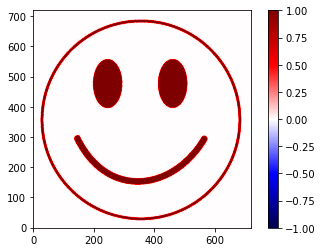

In [3]:
plt.imshow(im, origin = 'lower', vmin=-1, vmax=+1, cmap='seismic')
plt.colorbar()

In [4]:
#downsample
ds_factor = 8
im2 = block_reduce(im, block_size=(ds_factor,ds_factor), func=np.max)
im2.shape

(90, 90)

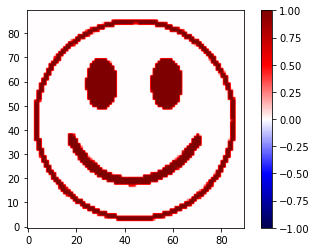

In [5]:
plt.imshow(im2, origin = 'lower', vmin=-1, vmax=+1, cmap='seismic')
plt.colorbar()

In [13]:
#normalization
alpha_scale = 1.5
alphas = np.linspace(-alpha_scale, alpha_scale, len(im2))
dx = alphas[1] - alphas[0]
i = np.trapz(np.trapz(im2))*dx**2
W = im2/i

In [14]:
print('max of W:' + str(np.max(W)))
if np.max(W) > 2/np.pi:
    print("Error: max should be smaller than 2/pi. This will set the alpha scale")

max of W:0.6923402815696381
Error: max should be smaller than 2/pi. This will set the alpha scale


In [15]:
# the purity 
p = np.trapz(np.trapz(W**2))*dx**2
p

0.6703350282019037

In [163]:
def plot_wigner(W, xvec):
    yvec = xvec
    dx = xvec[1] - xvec[0]
    dy = yvec[1] - yvec[0]
    extent = (xvec[0] - dx/2.0, xvec[-1] + dx/2.0, yvec[0] - dy/2.0, yvec[-1] + dy/2.0)
    plt.imshow((np.pi/2.0)*W, origin='lower', extent=extent, cmap='seismic', vmin=-1, vmax=+1, interpolation=None)
    plt.colorbar()
    plt.grid()

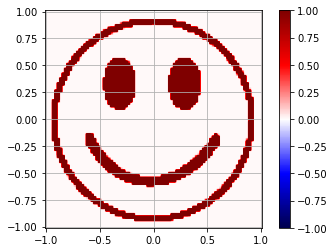

In [164]:
#plotting wigner
plot_wigner(W, alphas)

In [165]:
#The MLE
N = 40
xs_mesh, ys_mesh = np.meshgrid(alphas, alphas)
wigner_points = xs_mesh + 1j * ys_mesh
wigner_points = wigner_points.flatten()
wignerfunctomo = WignerTomography(dim=N)
wignerfunctomo.set_wigner_points(wigner_points)
A = wignerfunctomo.build_wigner_mat()
#THE WIGNER MLE EXPECTS PARITY, NOT WIGNER!
wigner_data = W.flatten()
wignerfunctomo.set_wigner_data(-1*wigner_data)

In [166]:
rho_mle = wignerfunctomo.reconstruct_state(recon_type='mle')

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 32107484
eps = 1.00e-04, alpha = 1.50, max_iters = 1000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 3242, constraints m = 22645
Cones:	primal zero / dual free vars: 3201
	soc vars: 16204, soc blks: 2
	sd vars: 3240, sd blks: 1
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.91e+19  3.51e+19  1.00e+00 -4.99e+25  1.92e+26  1.88e+26  5.35e-01 


In [ ]:
r_mle = qt.Qobj(np.array(rho_mle))
print('norm: %.6f' % (r_mle.norm()))
print('purity: %.6f' % np.real((r_mle**2).tr()))

In [ ]:
r_mle.isherm

In [144]:
def wigner(rho, xvec, yvec=None):
    if yvec is None:
        yvec = xvec
    return (np.pi / 2.0) * qt.wigner(rho, xvec, yvec, g=2)

In [145]:
alphas_resample = np.linspace(-5,5,101)
W_mle = wigner(r_mle, alphas_resample)

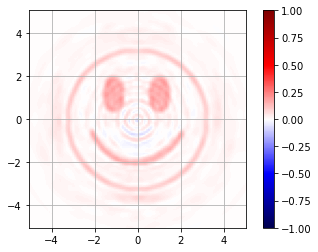

In [146]:
plot_wigner(W_mle, alphas_resample)

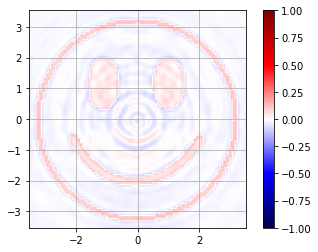

In [147]:
res = W - wigner(r_mle, alphas)
plot_wigner(res, alphas)

In [149]:
print(np.max(W))
print(np.max(W_mle))

0.12716454151279138
0.1326696037523441
